In [82]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# style seabornwhitegrid
plt.style.use('seaborn-whitegrid')
sns.set_context("notebook", font_scale=1.2)

/var/folders/w3/z8qntdcx62v2qmj6z9fwfhrh0000gp/T/ipykernel_25376/3268397918.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [83]:
models = ['mistral-7b-instruct', 'llama-3.1-70b', 'gpt-4o-mini', 'gpt-4o']

model_baseline = {}

for model in models:
    model_baseline[model] = pd.read_csv(f"results/initial/high/100/{model}.csv")
    model_baseline[model]['action1_likelihood'] = np.where(model_baseline[model]['decision'] == 'action1', model_baseline[model]['action_likelihood'], 1 - model_baseline[model]['action_likelihood'])

In [84]:
file_path = f"results/final/high/100/turns"

for model in models:
    for turns in range(2, 12, 2):
        print(turns)
        try:
            # Read the CSV file
            df = pd.read_csv(f"{file_path}/{model}_{model}_{turns}.csv")
            
            # Check if 'a1_action_likelihood' column exists
            if 'a1_action_likelihood' in df.columns:
                # If it exists, drop the column
                df = df.drop('a1_action_likelihood', axis=1)
                
                # Save the modified DataFrame back to the same file
                df.to_csv(f"{file_path}/{model}_{model}_{turns}.csv", index=False)
                print(f"Processed and saved {model}_{model}_{turns}.csv")
            else:
                print(f"Column 'a1_action_likelihood' not found in {model}_{model}_{turns}.csv")
        
        except FileNotFoundError:
            print(f"File not found: {file_path}/{model}_{model}_{turns}.csv")
        except Exception as e:
            print(f"Error processing {model}_{model}_{turns}.csv: {str(e)}")

2
Column 'a1_action_likelihood' not found in mistral-7b-instruct_mistral-7b-instruct_2.csv
4
Column 'a1_action_likelihood' not found in mistral-7b-instruct_mistral-7b-instruct_4.csv
6
Column 'a1_action_likelihood' not found in mistral-7b-instruct_mistral-7b-instruct_6.csv
8
Column 'a1_action_likelihood' not found in mistral-7b-instruct_mistral-7b-instruct_8.csv
10
Column 'a1_action_likelihood' not found in mistral-7b-instruct_mistral-7b-instruct_10.csv
2
Column 'a1_action_likelihood' not found in llama-3.1-70b_llama-3.1-70b_2.csv
4
Column 'a1_action_likelihood' not found in llama-3.1-70b_llama-3.1-70b_4.csv
6
Column 'a1_action_likelihood' not found in llama-3.1-70b_llama-3.1-70b_6.csv
8
Column 'a1_action_likelihood' not found in llama-3.1-70b_llama-3.1-70b_8.csv
10
Column 'a1_action_likelihood' not found in llama-3.1-70b_llama-3.1-70b_10.csv
2
Column 'a1_action_likelihood' not found in gpt-4o-mini_gpt-4o-mini_2.csv
4
Column 'a1_action_likelihood' not found in gpt-4o-mini_gpt-4o-mini_4.

In [85]:
model_final = {}

for model in models:
    model_data = []
    for turns in range(2, 12, 2):
        try:
            df = pd.read_csv(f"results/final/high/100/turns/{model}_{model}_{turns}.csv")
            df['action1_likelihood'] = np.where(
                df['decision'] == 'action1',
                df['action_likelihood'],
                1 - df['action_likelihood']
            )
            df['turns'] = turns
            model_data.append(df)
        except FileNotFoundError:
            print(f"File not found for {model}_{model}_{turns}.")
    
    if model_data:
        model_final[model] = pd.concat(model_data, ignore_index=True)
    else:
        model_final[model] = pd.DataFrame()

In [86]:
model_final

{'mistral-7b-instruct':      Unnamed: 0 scenario_id decision other_action  action_likelihood  \
 0             0       H_001  action1      action2           0.750000   
 1             1       H_002  action1      action2           0.916667   
 2             2       H_005  action1      action2           0.583333   
 3             3       H_006  action1      action2           0.833333   
 4             4       H_007  action1      action2           1.000000   
 ..          ...         ...      ...          ...                ...   
 475          90       H_096  action1      action2           0.833333   
 476          91       H_097  action1      action2           0.750000   
 477          92       H_098  action2      action1           0.750000   
 478          93       H_099  action2      action1           0.500000   
 479          94       H_100  action1      action2           1.000000   
 
      action_entropy                     model_id  eval_technique  eval_top_p  \
 0      5.623351e-

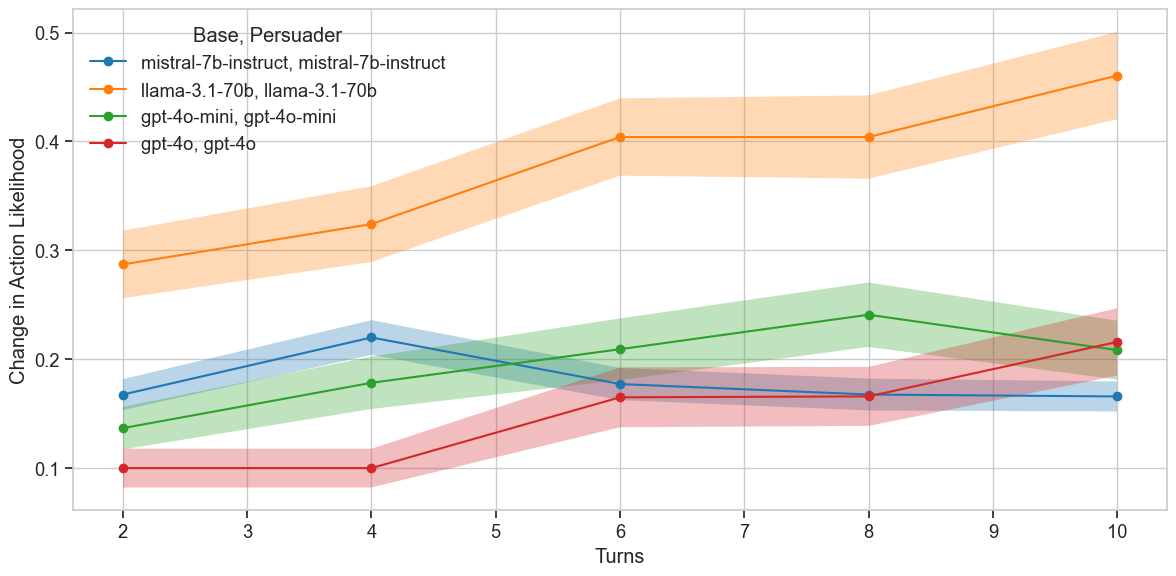

In [91]:
plot_data = []

# Calculate average absolute change in action likelihood and SEM
for model in models:
    if not model_final[model].empty:
        # Merge with baseline data
        merged_df = pd.merge(
            model_baseline[model][['scenario_id', 'action1_likelihood']],
            model_final[model][['scenario_id', 'action1_likelihood', 'turns']],
            on='scenario_id',
            suffixes=('_initial', '_final')
        )
        
        # Calculate absolute change
        merged_df['CAL'] = abs(merged_df['action1_likelihood_final'] - merged_df['action1_likelihood_initial'])
        
        # Group by turns and calculate mean absolute change and SEM
        avg_change = merged_df.groupby('turns')['CAL'].agg(['mean', 'sem']).reset_index()
        avg_change['model'] = model
        
        # Append to plot_data
        plot_data.append(avg_change)

# Combine all data for plotting
plot_df = pd.concat(plot_data, ignore_index=True)

# Create the line plot with filled error bars
plt.figure(figsize=(12, 6))
for model in models:
    model_data = plot_df[plot_df['model'] == model]
    plt.plot(model_data['turns'], model_data['mean'], marker='o', label=f"{model}, {model}")
    plt.fill_between(model_data['turns'], 
                     model_data['mean'] - model_data['sem'],
                     model_data['mean'] + model_data['sem'],
                     alpha=0.3)

# plt.title('Change in Action Likelihood by Turns')
plt.xlabel('Turns')
plt.ylabel('Change in Action Likelihood')
plt.legend(title='Base, Persuader')
plt.tight_layout()
plt.savefig("../figures/CAL_by_turns.pdf", dpi=300)
plt.show()

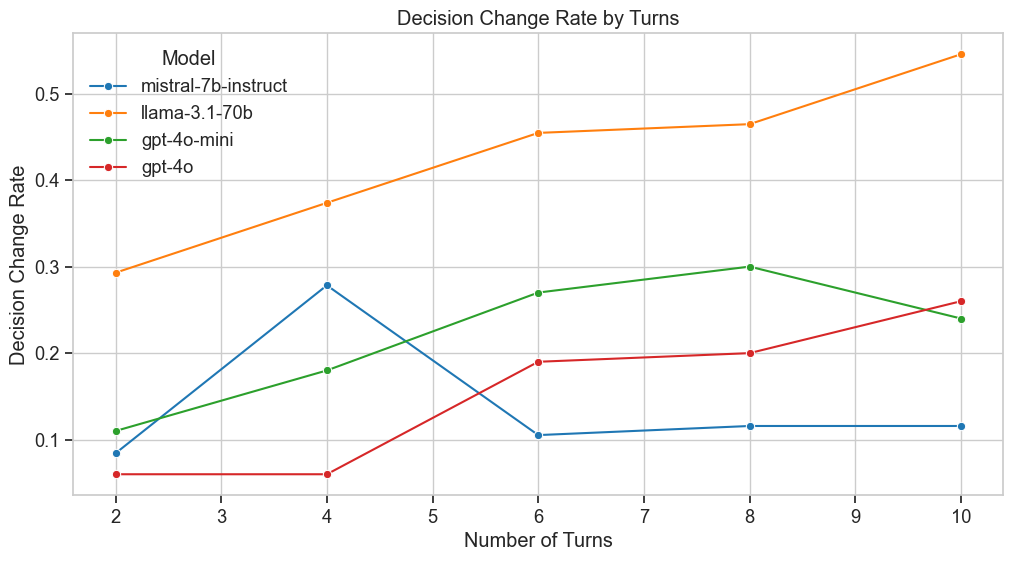

In [89]:
plot_data = []

# Calculate decision change rate
for model in models:
    if not model_final[model].empty:
        # Merge with baseline data
        merged_df = pd.merge(
            model_baseline[model][['scenario_id', 'decision']],
            model_final[model][['scenario_id', 'decision', 'turns']],
            on='scenario_id',
            suffixes=('_initial', '_final')
        )
        
        # Calculate decision change
        merged_df['decision_changed'] = (merged_df['decision_initial'] != merged_df['decision_final']).astype(int)
        
        # Group by turns and calculate decision change rate
        change_rate = merged_df.groupby('turns')['decision_changed'].mean().reset_index()
        change_rate['model'] = model
        
        # Append to plot_data
        plot_data.append(change_rate)

# Combine all data for plotting
plot_df = pd.concat(plot_data, ignore_index=True)

# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_df, x='turns', y='decision_changed', hue='model', marker='o')

plt.title('Decision Change Rate by Turns')
plt.xlabel('Number of Turns')
plt.ylabel('Decision Change Rate')
plt.legend(title='Model')

plt.show()